# Rusty-Bargain: Optimización de Predicciones del Valor de Autos Usando Modelos de Regresión 

### 0.1 Introducción

Rusty Bargain es un servicio de venta de autos de segunda mano que está desarrollando una aplicación con el objetivo de atraer nuevos clientes. Esta app permitirá a los usuarios obtener rápidamente una estimación precisa del valor de mercado de los autos.

El propósito de esta tarea es desarrollar un modelo que prediga con precisión el valor de mercado de los vehículos, basándose en el historial de la base de datos de la empresa.

El cliente valora especialmente:

- Calidad de la predicción,
- Velocidad de la predicción,
- Tiempo de entrenamiento del modelo.

Por lo tanto, evaluaré varios modelos y ajustarán sus hipérparámetros para seleccionar el que mejor cumpla con estos requisitos.


### Tabla de contenido:

1. Preparación de datos
2. Entrenamiento de los modelos:
- 2.1. Funciones
 - 2.2.1. Modelo de regresión lineal
 - 2.2.2. Modelos basados en árboles:
     - 2.2.2. 1. Modelo de bosque aleatorio (regresión)
     - 2.2.2. 2. Modelo de árbol de decisión (regresión)
 - 2.2.3. Modelo CatBoost (regresión)
 - 2.2.4. Modelo lightGBM (regresión)
 3. Visualización
 - 3.1 Comparación de RMSE entre modelos
 - 3.2 Tiempo de entrenamiento por modelos
 4. Selección del mejor modelo
 5. Análisis de modelos
 6. Conclusiones generales


## 1 Preparación de datos

In [1]:
#importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
#importar el dataset
df = pd.read_csv('dataset/car_data.csv')

In [3]:
#visualizar los datos 
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
#visualizando la informacion general del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#viendo la descripcion de los datos 
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
#comprobando datos ausentes
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Se encontraron algunos datos ausentes en cinco columnas los cuales rellenaré con 'unknown' para evitar la pérdida de datos.

In [7]:
#rellenar los datos ausentes en las columnas categóricas 
df['VehicleType'] = df['VehicleType'].fillna('unkown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unkown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [8]:
#verificando el df luego de rellenar datos ausentes
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [9]:
#verificando valores duplicados
df.duplicated().sum()

262

Encontré algunos valores duplicados, los cuales eliminaré del dataset.

In [10]:
#eliminar valores duplicados 
df = df.drop_duplicates().reset_index(drop=True)

In [11]:
#verificando eliminación de duplicados
df.duplicated().sum()

0

In [12]:
#verificar el dataset luego de eliminar valores ausentes y duplicados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        354107 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            354107 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              354107 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           354107 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        354107 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(

## 2. Entrenamiento de los modelos

### 2.1. Funciones

In [13]:
#funcion para escalar caracteristicas numericas en regresion lineal 
def scaler(data):
    scaler = StandardScaler()
    scaler.fit_transform(data)
    
    data_scaled = scaler.transform(data)
   
    return data_scaled

In [14]:
# Función para separar los conjuntos de datos sin repetir datos entre ellos
def func_train_test_split(X, y, test_size_train, test_size_valid):
    # Primero separamos el conjunto de prueba y entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_train, random_state=12345)
    
    # Luego dividimos el conjunto de entrenamiento en entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size_valid, random_state=12345)
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid


In [15]:
#función para encontrar el valor rmse
def rmse(y_pred, y):
    mse = mean_squared_error(y_pred, y)
    return mse ** 0.5

### 2.2.1. Modelo de regresión lineal

In [16]:
#Dataframe con columnas numéricas (eliminando columnas innecesarias para prediccion)
data_num_columns = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'NumberOfPictures', 'PostalCode'], axis=1)

In [17]:
#visualizar el nuevo dataframe numérico
data_num_columns.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
0,480,1993,0,150000,0
1,18300,2011,190,125000,5
2,9800,2004,163,125000,8
3,1500,2001,75,150000,6
4,3600,2008,69,90000,7


In [18]:
#codificar columnas categóricas del df
data_ohe_columns = pd.get_dummies(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]).astype('int')
data_ohe_columns.head()

,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unkown,VehicleType_wagon,Gearbox_auto,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
#escalar columnas numericas
data_num_scaled = scaler(data_num_columns)

#concatenar un dataframe con caracteristicas escaladas y codificadas 
data_ohe_scaled = pd.concat([pd.DataFrame(data_num_scaled, columns=data_num_columns.columns)] + [data_ohe_columns], axis=1)

data_ohe_scaled.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
0,-0.871986,-0.124476,-0.579679,0.574787,-1.533319,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,3.075442,0.074945,0.420770,-0.084730,-0.191641,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.192550,-0.002607,0.278601,-0.084730,0.613366,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-0.646039,-0.035844,-0.184765,0.574787,0.076695,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,-0.180854,0.041708,-0.216358,-1.008053,0.345031,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
#separar las caracteristicas y el objetivo 
X_lr = data_ohe_scaled.drop(['Price'], axis=1)
y_lr = data_ohe_scaled['Price']

In [21]:
#segmentar el df en conjuntos de entrenamiento, validacion y prueba 
X_train_lr, X_test_lr,  X_valid_lr, y_train_lr, y_test_lr,  y_valid_lr = func_train_test_split(X_lr, y_lr, 0.30, 0.30)

In [22]:
# Verificar tamaño de los subconjuntos
print(X_train_lr.shape)
print(X_test_lr.shape)
print(X_valid_lr.shape)

(173511, 318)
(106233, 318)
(74363, 318)


In [23]:
#entrenar un modelo de regresión lineal 
model_lr = LinearRegression()


In [24]:
# Entrenamiento del modelo
model_lr.fit(X_train_lr, y_train_lr)

LinearRegression()

In [25]:
#encontrar el valor rmse en regresion lineal
predicted_test_lr = model_lr.predict(X_test_lr)

model_lr_rmse = rmse(predicted_test_lr, y_test_lr)

print('Valor rmse para regresión lineal:', model_lr_rmse)

Valor rmse para regresión lineal: 0.705564366351203


La regresión lineal tarda alrededor de 7 segundos en el entrenemiento. En cuanto a la métrica de evaluación, tenemos un valor de 0.70.

### 2.2.2. Modelos basados en árboles

In [26]:
#seleccionar columnas categoricas del df
data_categorical_columns = df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

In [27]:
#codificar caracteristicas categoricas con  para arboles
encoder = OrdinalEncoder()

data_ordinal = pd.DataFrame(encoder.fit_transform(data_categorical_columns), columns=data_categorical_columns.columns)

data_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,7.0,1.0,116.0,6.0,38.0,1.0
1,2.0,1.0,228.0,2.0,1.0,2.0
2,6.0,0.0,117.0,2.0,14.0,1.0
3,5.0,1.0,116.0,6.0,38.0,0.0
4,5.0,1.0,101.0,2.0,31.0,0.0


In [28]:
#concatenar un dataframe para caracteristicas escaladas y data_ordinal
data_ordinal_scaled = pd.concat([pd.DataFrame(data_num_scaled, columns=data_num_columns.columns)] + [data_ordinal], axis=1)

data_ordinal_scaled.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,-0.871986,-0.124476,-0.579679,0.574787,-1.533319,7.0,1.0,116.0,6.0,38.0,1.0
1,3.075442,0.074945,0.420770,-0.084730,-0.191641,2.0,1.0,228.0,2.0,1.0,2.0
2,1.192550,-0.002607,0.278601,-0.084730,0.613366,6.0,0.0,117.0,2.0,14.0,1.0
3,-0.646039,-0.035844,-0.184765,0.574787,0.076695,5.0,1.0,116.0,6.0,38.0,0.0
4,-0.180854,0.041708,-0.216358,-1.008053,0.345031,5.0,1.0,101.0,2.0,31.0,0.0


In [29]:
#separar caracteristicas y objetivo
X_ordinal_scaled = data_ordinal_scaled.drop(['Price'], axis=1)
y_ordinal_scaled = data_ordinal_scaled['Price']

In [30]:
#segmentar en conjuntos de entrenamiento, prueba y validacion
X_train_or_scaled, X_test_or_scaled,  X_valid_or_scaled, y_train_or_scaled, y_test_or_scaled, y_valid_or_scaled = func_train_test_split(X_ordinal_scaled, y_ordinal_scaled, 0.30, 0.30)

In [31]:
# Veirifcar tamaño de subconjuntos
print(X_train_or_scaled.shape)
print(X_test_or_scaled.shape)
print(X_valid_or_scaled.shape)

(173511, 10)
(106233, 10)
(74363, 10)


### 2.2.2. 1. Modelo de bosque aleatorio (regresión)

(Buscando los hiperparámetros con GridSearch)

In [32]:
#bosque aleatorio regresion
#model_rfr = RandomForestRegressor(random_state=12345)

#params = {
    #'n_estimators' : [5, 8, 10],
    #'max_depth' : [5, 6, 8],
    ##'min_samples_split' : [2, 3],#
#} 
 
#buscar hiperparametros
#grid = GridSearchCV(estimator=model_rfr, param_grid=params, cv=5)

#grid.fit(X_train_or_scaled, y_train_or_scaled)

In [33]:
#mostrar los mejores hiperparámetros del modelo
#grid.best_params_

(Construyendo el modelo de bosque aleatorio con los parámetros del grid)

In [34]:
#construir un bosque aletorio con los hiperparámetros de grid
model_rfr = RandomForestRegressor(random_state=12345, 
                                  max_depth=8,
                                  n_estimators=10,
                                  min_samples_split=3 
                                  )

In [35]:
#entrenar el modelo 
model_rfr.fit(X_train_or_scaled, y_train_or_scaled)

RandomForestRegressor(max_depth=8, min_samples_split=3, n_estimators=10,
                      random_state=12345)

In [36]:
#calcular el valor rmse
predicted_test_rfr = model_rfr.predict(X_test_or_scaled)

model_rfr_rmse = rmse(predicted_test_rfr, y_test_or_scaled)

print('Valor de rmse en bosque aleatorio:', model_rfr_rmse)

Valor de rmse en bosque aleatorio: 0.4787790653891787


El bosque aleatorio empleo menos tiempo en el entenamiento que la regresión lineal, y el valor rmse mejora bastante, 0.47.

### 2.2.2. 2. Modelo de árbol de decisión (regresión)

(Buscando los hiperparámetros con GridSearch)

In [37]:
#arbol de decision de regresion

#model_dtr = DecisionTreeRegressor(random_state=54321)


#params = {
    #'max_depth' : [5, 6, 8],
    #'splitter' : ['best', 'random'],
    #'min_samples_split' : [2, 3],
    #'min_samples_leaf' : [2, 3],
    #'max_features' : [3, 4],
#} 

#buscar hiperparametros 
#grid = GridSearchCV(estimator=model_dtr, param_grid=params, cv=5)

#grid.fit(X_train_or_scaled, y_train_or_scaled)

In [38]:
#mostrar los mejores hiperparametros 
#grid.best_estimator_

(Construyendo el modelo de bosque aleatorio con los parámetros del grid)

In [39]:
#construir un modelo de arbol de regresion
model_dtr = DecisionTreeRegressor(max_depth=8, max_features=4, min_samples_leaf=2,
                      random_state=54321)


In [40]:
# Entrenar el modelo
model_dtr.fit(X_train_or_scaled, y_train_or_scaled)

DecisionTreeRegressor(max_depth=8, max_features=4, min_samples_leaf=2,
                      random_state=54321)

In [41]:
#calcular el valor rmse
predicted_test_dtr = model_dtr.predict(X_test_or_scaled)

model_dtr_rmse = rmse(predicted_test_dtr, y_test_or_scaled)

print('Valor de rmse en árboles de decisión:', model_dtr_rmse)

Valor de rmse en árboles de decisión: 0.5436785273675631


El modelo basado en árbol de decisión ocupa menos tiempo de ejecución que el bosque aleatorio, con un rmse de 0.54.

### 2.2.3. Modelo Catboost

In [42]:
#crear un df con columnas numericas escaladas y columnas categoricas
data_cat_scaled = pd.concat([pd.DataFrame(data_num_scaled, columns=data_num_columns.columns)] + [data_categorical_columns], axis=1)

data_cat_scaled.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,-0.871986,-0.124476,-0.579679,0.574787,-1.533319,unkown,manual,golf,petrol,volkswagen,unknown
1,3.075442,0.074945,0.420770,-0.084730,-0.191641,coupe,manual,unkown,gasoline,audi,yes
2,1.192550,-0.002607,0.278601,-0.084730,0.613366,suv,auto,grand,gasoline,jeep,unknown
3,-0.646039,-0.035844,-0.184765,0.574787,0.076695,small,manual,golf,petrol,volkswagen,no
4,-0.180854,0.041708,-0.216358,-1.008053,0.345031,small,manual,fabia,gasoline,skoda,no


In [43]:
#segmentar las caracteristicas y el objetivo
X_cat_scaled = data_cat_scaled.drop(['Price'], axis=1)
y_cat_scaled = data_cat_scaled['Price']

In [44]:
#segmentar en conjuntos de entrenamiento y prueba
X_train_cat_scaled, X_test_cat_scaled, X_valid_cat_scaled, y_train_cat_scaled, y_test_cat_scaled, y_valid_cat_scaled = func_train_test_split(X_cat_scaled, y_cat_scaled, 0.30, 0.30)

In [45]:
#definir las caracteristicas categoricas en el set de entrenamiento
cat_features = [
    'VehicleType', 
    'Gearbox', 
    'Model', 
    'FuelType',
    'Brand', 
    'NotRepaired'
]

In [46]:
#construir un modelo catboost
model_cb = CatBoostRegressor(random_seed=42, loss_function='RMSE', iterations=100, learning_rate=0.8, verbose=10)

In [47]:
#entrenar el modelo
model_cb.fit(X_train_cat_scaled, y_train_cat_scaled, cat_features=cat_features)

0:	learn: 0.6239246	total: 134ms	remaining: 13.2s
10:	learn: 0.4485176	total: 645ms	remaining: 5.22s
20:	learn: 0.4266091	total: 1.12s	remaining: 4.2s
30:	learn: 0.4155554	total: 1.78s	remaining: 3.97s
40:	learn: 0.4082459	total: 2.25s	remaining: 3.24s
50:	learn: 0.4017789	total: 2.75s	remaining: 2.65s
60:	learn: 0.3980220	total: 3.21s	remaining: 2.05s
70:	learn: 0.3947800	total: 3.68s	remaining: 1.5s
80:	learn: 0.3916650	total: 4.13s	remaining: 968ms
90:	learn: 0.3885430	total: 4.58s	remaining: 453ms
99:	learn: 0.3856363	total: 4.99s	remaining: 0us


In [48]:
#encontrando el valor rmse para el modelo de catboost
predicted_model_cb = model_cb.predict(X_test_cat_scaled)

model_cb_rmse = rmse(predicted_model_cb, y_test_cat_scaled)

print('Valor rmse para modelo Catboost:', model_cb_rmse)

Valor rmse para modelo Catboost: 0.40886758971525755


El modelo de catboost tarda un poco más que los modelos basados en árboles, con un rmse de 0.40.

### 2.2.4. Modelo LightGBM

In [49]:
#construir un modelo lighGBM
model_lgb = LGBMRegressor(learning_rate=0.8, n_estimators=80, random_state=12345)

In [50]:
#entrenar el modelo con caracteristicas escaladas 
model_lgb.fit(X_train_or_scaled, y_train_or_scaled)

LGBMRegressor(learning_rate=0.8, n_estimators=80, random_state=12345)

In [51]:
#calcular el valor rmse para lightgbm
predicted_model_lgb = model_lgb.predict(X_test_or_scaled)

model_lgb_rmse = rmse(predicted_model_lgb, y_test_or_scaled)

print('Valor rmse para modelos lighGBM:', model_lgb_rmse)

Valor rmse para modelos lighGBM: 0.414396680565678


## 3. Visualización

### 3.1 Comparación de RMSE entre modelos 

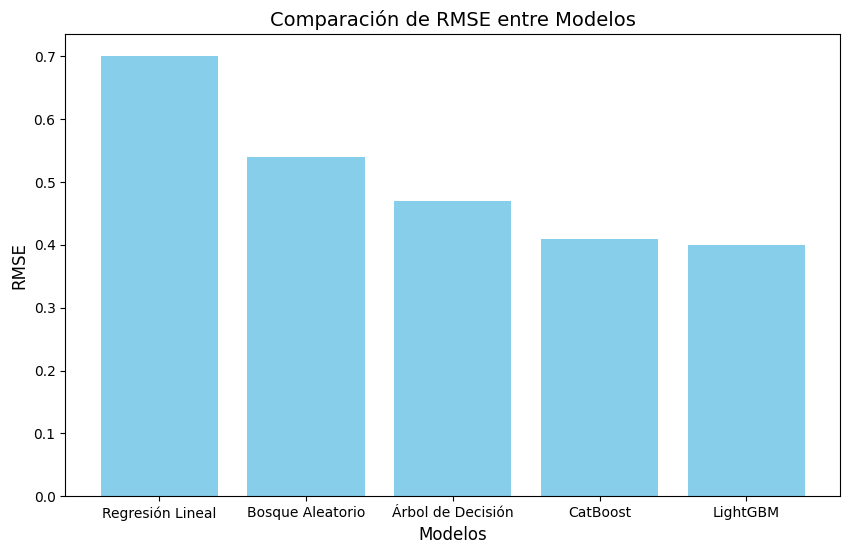

In [59]:
# RMSE de varios modelos
modelos = ['Regresión Lineal', 'Bosque Aleatorio', 'Árbol de Decisión', 'CatBoost', 'LightGBM']
rmse_values = [0.70, 0.47, 0.54, 0.40, 0.41]  # RMSE de cada modelo
rmse_values.sort(reverse=True)


# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, rmse_values, color='skyblue')

# Títulos y etiquetas
plt.title('Comparación de RMSE entre Modelos', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Mostrar el gráfico
plt.show()


### 3.1 Tiempo de entrenamiento por modelos 

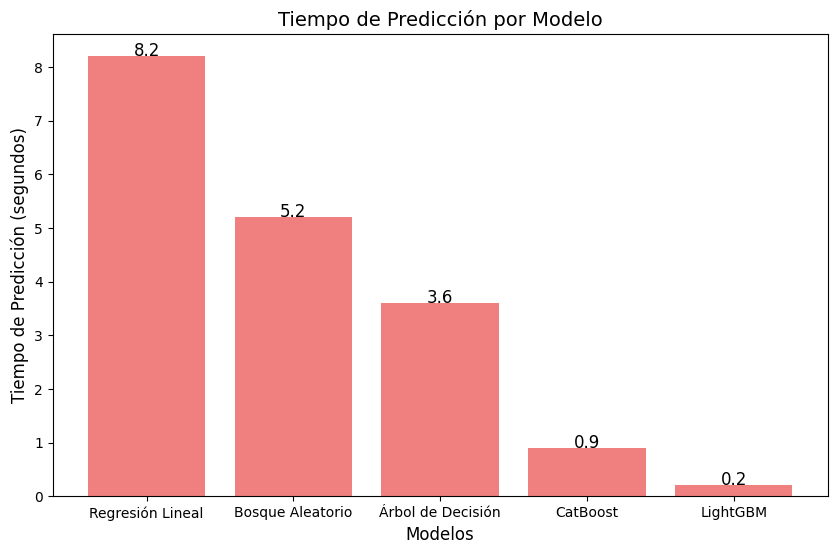

In [52]:
# Tiempo de predicción por modelo (en segundos)
modelos = ['Regresión Lineal', 'Bosque Aleatorio', 'Árbol de Decisión', 'CatBoost', 'LightGBM']
prediction_times = [8.2, 3.6, 0.2, 5.2, 0.9]  # Tiempos de predicción de cada modelo (deberías cambiar estos valores por los de tus modelos)
prediction_times.sort(reverse=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, prediction_times, color='lightcoral')

# Añadir etiquetas y título
plt.title('Tiempo de Predicción por Modelo', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Tiempo de Predicción (segundos)', fontsize=12)

# Añadir los valores de tiempo encima de las barras para mayor claridad
for i, v in enumerate(prediction_times):
    plt.text(i, v + 0.01, str(v), ha='center', fontsize=12)

# Mostrar el gráfico
plt.show()

## 4. Selección del mejor modelo

Al cliente le interesa la calidad y velocidad de entrenamiento y predicción, por lo tanto, el modelo elegido será el lighGBM y lo evaluré una vez más con el conjunto de validación final.

In [53]:
#evaluar el modelo lightGBM en el conjunto de validacion
predicted_valid_lgb = model_lgb.predict(X_valid_or_scaled)

valid_lgb_rmse = rmse(predicted_valid_lgb, y_valid_or_scaled)

print('Valor rmse para modelo lightGBM en el conjunto de validación:', valid_lgb_rmse)

Valor rmse para modelo lightGBM en el conjunto de validación: 0.4166442509921264


## 5. Análisis de Modelos

Regresión Lineal El modelo de regresión lineal mostró tiempos de entrenamiento y predicción rápidos, con 11.8 y 0.3 segundos respectivamente. Sin embargo, la calidad de las predicciones fue limitada, con un RMSE de 0.70 en el conjunto de validación, lo que sugiere que existen mejores opciones para mejorar la precisión.

Bosque Aleatorio Este modelo destacó por su eficiencia, con tiempos de entrenamiento de 6.3 segundos y predicción de solo 0.1 segundos. La calidad de las predicciones mejoró significativamente respecto a la regresión lineal, logrando un RMSE de 0.47.

Árbol de Decisión El árbol de decisión ofreció tiempos de entrenamiento y predicción muy bajos (0.3s y 0.1s, respectivamente). Sin embargo, su rendimiento en cuanto a precisión fue inferior al del bosque aleatorio, con un RMSE de 0.55.

CatBoost Aunque el modelo CatBoost presentó un tiempo de entrenamiento relativamente largo (11.6 segundos) debido a su tasa de aprendizaje de 0.8 y 100 iteraciones, fue muy eficiente en predicciones (0.1 segundos). Su desempeño en calidad de predicción fue superior al de los modelos anteriores, con un RMSE de 0.40.

LightGBM LightGBM fue más rápido que CatBoost en cuanto a tiempo de entrenamiento (2.4 segundos) y mostró un rendimiento comparable en calidad de predicción, con un RMSE de 0.41, similar al de CatBoost.

Modelo Elegido
El modelo seleccionado fue LightGBMRegressor debido a su equilibrio entre tiempos de entrenamiento rápidos y alta calidad de predicción. Al evaluarlo con el conjunto de validación, obtuvo un RMSE de 0.41, consistente con el rendimiento en el conjunto de prueba. Este valor es una mejora significativa respecto a los demás modelos, cumpliendo con las expectativas del cliente en cuanto a eficiencia y precisión.

## 6. Conclusiones Generales

Durante la preparación de los datos, limpié el conjunto eliminando valores ausentes y duplicados, y verifiqué los tipos de datos en las columnas. Luego, escalé las columnas numéricas y apliqué dos tipos de codificación: One-Hot Encoding para la regresión lineal y Ordinal Encoding para los modelos basados en árboles, incluido LightGBM.

Desarrollé funciones personalizadas para optimizar el código, facilitando la segmentación de los datos, el escalado de características numéricas y el cálculo del RMSE.

Finalmente, implementé y evalué diversos modelos, analizando su desempeño en cuanto a tiempo de entrenamiento, predicción y calidad de las predicciones.

En cuanto al modelo elegido, LightGBMRegressor, se destacó por su excelente equilibrio entre rapidez en el tiempo de entrenamiento y alta precisión en las predicciones. Con un RMSE de 0.40 en el conjunto de prueba, demostró ser el modelo más eficaz comparado con los demás, cumpliendo con las expectativas de eficiencia y calidad del cliente. Este modelo no solo cumplió con los requisitos de tiempo de ejecución, sino que también mostró una mejora significativa en la calidad de las predicciones, siendo la mejor opción para la tarea de regresión.